# CCD Basics III Spectroscopy: Extracting and wavelength calibrating spectral data
________________________________________________________________________________________

This exercise is adapted from an introductory tutorial to IRAF (Image Reduction and Analysis Facility): http://iraf.noao.edu/ 

The IRAF tools are now no longer supported by the National Optical Astronomy Observatory, but most have been imported into equivalent python routines within the Astropy package. Right now, however, we're just using basic image math to apply the necessary corrections to data frames.

In the previous exercise you did the preliminary reductions of spectroscopic CCD data. Here, we will learn how to extract the spectrum from the CCD chip and perform wavelength calibration, i.e. relating pixel location to wavelength of the dispersed light.

The spectra for this exercise were taken at the Coude Feed telescope at Kitt Peak National Observatory by Dr. Phil Massey. The files are called sp\*.fits, and are found in on vega2 in /data/ASTR303/HW4).

## Objective
The purpose of this part of the tutorial is to take the full reduced CCD frames (i.e. overscan-trimmed, bias-subtracted, and flat-fielded) still containing all the pixels on the chip, and extract only the part that is useful for analysis, i.e. the spectrum of the object. Finally, we must map pixels on the chip to wavelength in order to have the fully calibrated spectrum. 

There may be some contexts in which there is more than one spectrum on the chip, with grism, or multi-object spectroscopy with optical fibers, but here, we want to extract a single 1-dimensional spectrum, a single column (or average of a few columns) on the CCD- but remember, this will be rows on the CCD for spectra taken at the 16" telescope! Once we do our dispersion solution relating pixel location to wavelength, we will be able to make a graph of object flux versus wavelength, i.e. we will have a spectrum we can analyze.

### Sky Background
The first step we must take is to subtract the sky background, just as you did for the star in HW1. However, now we must do this at each pixel(soon to be mapped to wavelength) in the dispersion direction.



In [9]:
# initial imports
import numpy as np
import matplotlib.pyplot as plt

# change some default plotting parameters
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'Greys_r'

# run the %matplotlib magic command to enable inline plotting
# in the current Notebook
%matplotlib inline

#import astropy fits file handling package
from astropy.io import fits
import os
biasCor=os.listdir('biasCor')
objectFlats=os.listdir('objectFlats')
trimSpec=os.listdir('trimSpec')



Let's load one of our flattened object frames and plot the counts along line 512 in the middle of the chip.

In [3]:
sci_fn="objectFlats/flat_sp0020.fits"
sci_hdulist = fits.open(sci_fn)
spec = sci_hdulist[0].data.astype(np.float)

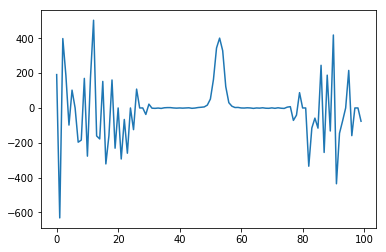

In [4]:
plt.figure()  # Start a new plot -- by default matplotlib overplots.
plt.plot(spec[512,:])


Recall from the ccd2 tutorial that the sky + object extends between columns 33-75. Now adjust the command above to plot line 512 across only those columns. 

We'll use columns 33-45 (x=0-12 in your new plot above) and 60-75 (x=27-42 in the plot above) to estimate the sky background to the left/right of our object in the spatial direction.  

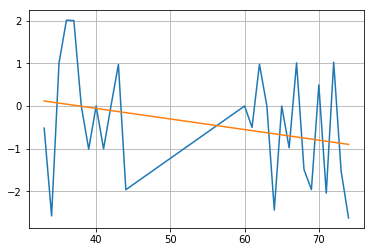

In [5]:
x = np.append(np.arange(33, 45), np.arange(60, 75))  # Background rows
y = spec[512, x]  # Background columns in row 512
plt.figure()
plt.plot(x, y)
pfit = np.polyfit(x, y, 1)  # Fit a 1st order polynomial to (x, y) data
yfit = np.polyval(pfit, x)  # Evaluate the polynomial at x
plt.plot(x, yfit)
plt.grid()

**QUESTION** Add cells below to calculate the mean of the background in this flattened image in these selected columns in row 512, and then over all rows of the chip. (Hint: use the y array defined in the cell above.)


In [6]:
print(np.mean(y))
print(np.mean(spec))

-0.4120564502268434
-7.795318912584249


There is not a large contribution from the sky on either side of the object spectrum, but let's subtract it anyway, so you know the procedure.

In [7]:
xcols = np.arange(spec.shape[1])            # Array from 0 .. N_rows-1
bkg = np.zeros_like(spec)                   # Empty image for background fits
for row in np.arange(spec.shape[0]):        # For each row ...
    pfit = np.polyfit(x, spec[row,x], 1)    # Fit poly over bkg col for row
    bkg[row,:] = np.polyval(pfit, xcols)    # Eval poly at ALL row positions

Note: This is somewhat similar to the technique in the ccd2 tutorial to fit the illumination function.  <br><br>

Now, let's subtract the background and inspect the background-subtracted frame:

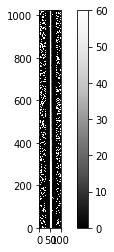

In [8]:
spec_bkg = spec - bkg
plt.clf()
plt.imshow(spec_bkg, origin = 'lower', vmin=0, vmax=60)
plt.colorbar()

Apply to other five spectrum frames (we're actually doing the first one over again in the loop below.)

In [14]:
# dt=np.dtype([('filename', np.unicode, 20)])
# files=np.genfromtxt("sp_obj.list",dtype=dt)
# infiles=files['filename']

for file in objectFlats:
    sci_fn = 'objectFlats/'+file
    out= "bkg/bkg_"+file
    flatspec = fits.open(sci_fn)[0].data.astype(np.float)
    x = np.append(np.arange(33, 45), np.arange(60, 75))  
    y = flatspec[512, x]  
    pfit = np.polyfit(x, y, 1)  
    xcols = np.arange(flatspec.shape[1])            # Array from 0 .. N_rows-1
    bkg = np.zeros_like(flatspec)                   # Empty image for background fits
    for row in np.arange(flatspec.shape[0]):        # For each row ...
       pfit = np.polyfit(x, flatspec[row,x], 1)     # Fit poly over bkg col for row
       bkg[row,:] = np.polyval(pfit, xcols)         # Eval poly at ALL row positions
    bkgsub=flatspec-bkg
    hdu = fits.PrimaryHDU(bkgsub)
    hdu.writeto(out, overwrite=True)

Inspect one or two of these newly-created "bkg_sp\*.fits" frames using ds9.

### Spectrum extraction
Now we're ready to extract the 1D spectra from the background-subtracted frame, and then to extract the calibration lamp spectra the same way. Let's first inspect a plot of one of these background-subtracted frames across line 512:

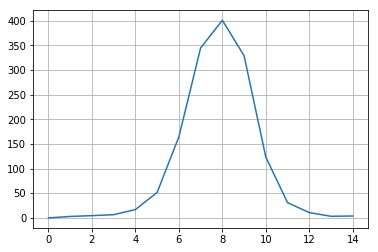

In [15]:
plt.figure()  
plt.plot(bkgsub[512,45:60])  #This is the last frame from the loop above
plt.grid()

From this, we see that most of the flux is in columns (45+7)=52 through (45+9)=54. 

**QUESTION** Add four cells below with this plot made across other lines of the frame that span the range on the chip. Determine whether or not these columns (52-54) are the best columns to use for all lines, i.e. you are determining whether or not the dispersed light is straight down the columns or at an angle. You can also inspect this using ds9.

From what I've seen from these plots and ds9, columns 52-54 seem to be the most appropriate throughout the frame


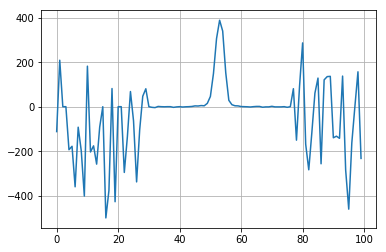

In [17]:
plt.figure()
plt.plot(bkgsub[420])
plt.grid()

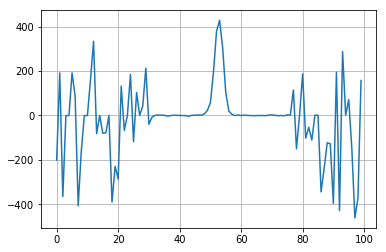

In [21]:
plt.figure()
plt.plot(bkgsub[633])
plt.grid()

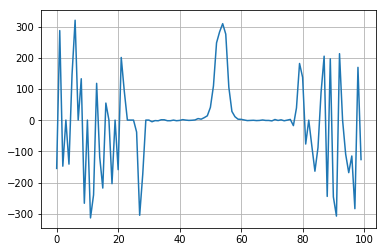

In [20]:
plt.figure()
plt.plot(bkgsub[1])
plt.grid()

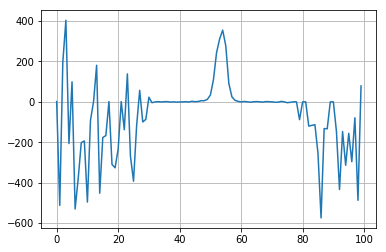

In [23]:
plt.figure()
plt.plot(bkgsub[69])
plt.grid()

We can also use a function to find the position of the maximum of the flux along each row of the CCD, as in the cell below. In some rows, the column number containing the maximum flux (the value of the speccol array) is outside the range 52-54 due to hot pixels. We'll restrict the plot to show only y=50-58 to narrow the view in the plot window. 

Use the # symbol to comment out this line in order to see what the plot looks like without it.

Now, uncomment both the plt.ylim command and the plt.xlim command and adjust the values of xlim to get different ranges of rows in the plot.

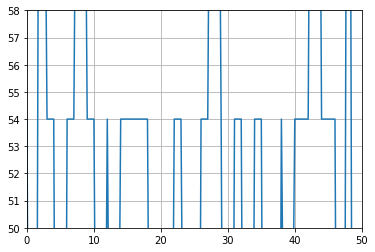

In [34]:
speccol=np.argmax(bkgsub,axis=1)
len(bkgsub[:,52])
x=np.arange(0, len(bkgsub[:,52]))
plt.figure()  
plt.ylim(50,58)     
plt.xlim(0,50) 
plt.plot(x,speccol)  
plt.grid()

From this, we see that the true trace of the spectrum does shift a bit from column 54 to 53 to 52 across the rows. But if we take an average of the flux in these 3 columns, we should be ok. If we wanted to be precise, we'd fit a slowly varying function to the value of the maximum and extract the column numbers given by that function across all rows of the CCD. This is called the *trace* of the spectrum on the CCD.

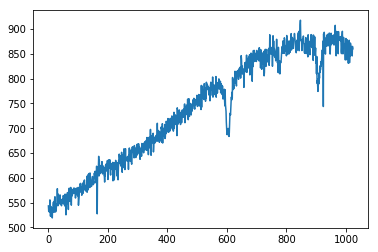

In [35]:
ext_spec = bkgsub[:,52:54].sum(axis=1)
plt.figure()   
plt.plot(ext_spec) 

Let's extract all the object spectra the same way. This time, we won't write out FITS files but instead we'll retain the array for each object frame to use below.

In [38]:
# dt=np.dtype([('filename', np.unicode, 20)])
# files=np.genfromtxt("sp_obj.list",dtype=dt)
# infiles=files['filename']
ext_spec=np.ones((len(objectFlats),1024))

for i in range (0,len(objectFlats)):
    sci_fn = "bkg/bkg_"+objectFlats[i]
    sci_hdulist = fits.open(sci_fn)
    bkgspec = sci_hdulist[0].data.astype(np.float)
    ext_spec[i,:] = bkgspec[:,52:54].sum(axis=1)
    

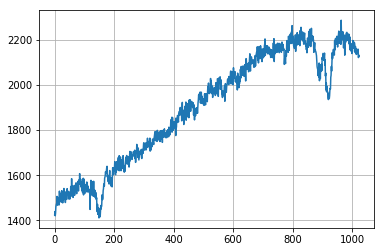

In [39]:
plt.figure()  
plt.plot(ext_spec[0])
plt.grid()

We now have reduced, extracted spectra in arrays labeled ext_spec[0], ext_spec[1], etc.

### Dispersion solution
We are now ready to find the dispersion solution and apply it. To do this, we must use the calibration lamp spectrum and identify as many lines as we can. In most cases, you want to use calibration lamp spectra taken at the same telescope position as the object spectrum. This accounts for small wavelength shifts that can arise from flexture in the instrument as it as placed at different angles to point the telescope.

First, we'll extract the comparison spectra the same way we did the data spectra, and plot one of them.

In [48]:
comp_fn="data/sp0018.fits"
comp_hdulist = fits.open(comp_fn)
comp = comp_hdulist[0].data.astype(np.float)
ext_comp1= comp[:,52:54].sum(axis=1)

comp_fn="data/sp0027.fits"
comp_hdulist = fits.open(comp_fn)
comp = comp_hdulist[0].data.astype(np.float)
ext_comp2= comp[:,52:54].sum(axis=1)

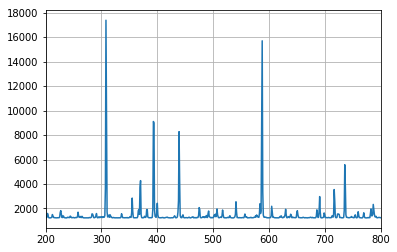

In [49]:
plt.figure()  # Start a new plot -- by default matplotlib overplots.
plt.plot(ext_comp1)
plt.xlim(200, 800) 
plt.grid()

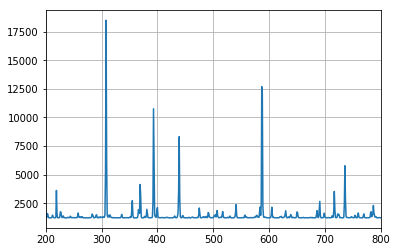

In [52]:
plt.figure()  # Start a new plot -- by default matplotlib overplots.
plt.plot(ext_comp2)
plt.xlim(200, 800) 
plt.grid()

Copy the marked calibration lamp spectrum using scp, from /data/ASTR303/HW4/spec.pdf This plot shows the positions of the lines.

**QUESTION** Compare this plot with the frame of the comparison spectrum in ds9.(This frame has not been bias-subracted, flat-fielded, or background subtracted, which is fine.) Note that the height of the emission lines corresponds to how bright they appear in the ds9 window. Does left to right in the plot (increasing wavelength) run downwards in the frame or upwards?

It runs upwards.  200 is at the bottom, 800 at the top

Now, you need to identify several lines in the spectrum and associate them with rows on the CCD. You can do this by zooming in on the plot above- by uncommenting and adjusting the xlim command above. For example, the strong line at 4609.5673 A lies at pixel (row) 308.

It is ok to use half pixel values in cases where the line maximum spreads across 2 pixels.


**QUESTION** Complete the following tables:

| sp0018.fits|         |
|------------|---------|
| wavelength | pixel   |
|------------|---------|      
|  4673.6609 |         |
|------------|---------|
|  4657.9012 |         |
|------------|---------|
|  4609.5673 | 308     |
|------------|---------|
|  4589.8978 |         |
|------------|---------|
|  4579.3495 |         |
|------------|---------|
|  4545.0519 |         |
|------------|---------|
|  4493.3337 |         |
|------------|---------|
|  4481.8107 |         |
|------------|---------|
|  4474.7594 |         |
|------------|---------|
|  4445.9012 |         |
|------------|---------|

Change the spectrum plotted by changing ext_comp1 to ext_comp2 and again, use the xlim command to zoom in and find the pixel values for each line. The 4609.5673 line falls at pixel 308, as above. Other lines may be at the same pixel positions as in the above table, or at slightly different positions. 

| sp0027.fits|         |
|------------|---------|
| wavelength | pixel   |
|------------|---------|      
|  4673.6609 |         |
|------------|---------|
|  4657.9012 |         |
|------------|---------|
|  4609.5673 | 308     |
|------------|---------|
|  4589.8978 |         |
|------------|---------|
|  4579.3495 |         |
|------------|---------|
|  4545.0519 |         |
|------------|---------|
|  4493.3337 |         |
|------------|---------|
|  4481.8107 |         |
|------------|---------|
|  4474.7594 |         |
|------------|---------|
|  4445.9012 |         |
|------------|---------|
  
  

Make three arrays, two with the pixel values (x1 for sp0018 and x2 for sp0027), the other with the wavelengths of the identified lines (y). You need to fill in the pixel values for x1 and x2 from your table above.

Next, we fit a polynomial to these points. The yfit is the dispersion function. We'll apply it to the pixel arrays from our extracted spectra to get the final arrays of wavelength and flux.

In [ ]:
x1=[(your 10 pixel values from above for sp0018)]
x2=[(your 10 pixel values from above for sp0027)]
y=[4673.6609,4657.9012,4609.5673,4589.8978,4579.3495,4545.0519,4493.3337,4481.8107,4474.7594,4445.9012]

In [ ]:
pfit1 = np.polyfit(x1, y, 1)  # Fit a 1st order polynomial to (x1, y) data
yfit1 = np.polyval(pfit, x1)  # Evaluate the polynomial at x1
plt.plot(x1, yfit1)
plt.scatter(x1,y)
plt.grid()

In [ ]:
pfit2 = np.polyfit(x2, y, 1)  # Fit a 1st order polynomial to (x1, y) data
yfit2 = np.polyval(pfit, x1)  # Evaluate the polynomial at x1
plt.plot(x2, yfit2)
plt.scatter(x,y)
plt.grid()

Now we evaluate our polynomial over all rows, 1-1024 and use it to extract the data spectra.

**QUESTION** Use the fitsheader command at the astroconda command line to find the UT of each comparision spectrum and data frame. Paste the output here in this cell:




**QUESTION** Based on which calibration spectrum was taken closest in time to each data spectrum, complete the table below to indicate which comparison spectrum (ext_comp1 from sp0018 or ext_comp2 from sp0027) to use with each data spectrum, ext_spec0, ext_spec1, etc., e.g.

| spectrum     | calibration |
|--------------|-------------|      
| ext_spec[0]  | ext_comp1   |
|--------------|-------------|
| ext_spec[1]  |             |
|--------------|-------------| 
| ext_spec[2]  |             |
|--------------|-------------| 
| ext_spec[3]  |             |
|--------------|-------------|
| ext_spec[4]  |             |
|--------------|-------------|
| ext_spec[5]  |             |


Remember, if you have multiple objects observed over the course of the night, you want to take a calibration lamp at each position the telescope is pointed in the sky. 

**QUESTION** In the situation just described, you might want to match up data frames with calibration spectra using the which header keywords?


Now, use the dispersion solution from the appropriate comparison spectrum (pfit1 or pfit2) for each data spectrum, as in the example below. Add cells to perform the calculations.

In [ ]:
xrow=np.arange(0, 1024)
wavefit1=np.polyval(pfit1, xrow)
plt.plot(wavefit1,ext_spec[0])
plt.grid()

We'll write the wavelength and flux arrays out into FITS TABLE (rather than a FITS image, as we've been working with). In most applications, we would also want to keep a running tally of our error array and write that into the FITS table as well. We'll learn about the function we would use for this later in Chapter 9.

Here's one example for writing out the spectrum. Add cells below to write out the others.

In [ ]:
col1 = fits.Column(name='Wavelength', format='E', array=wavefit1)
col2 = fits.Column(name='Flux', format='E', array=ext_spec[0])
cols = fits.ColDefs([col1, col2])
tbhdu = fits.BinTableHDU.from_columns(cols)
tbhdu.writeto('spec1.fits')